In [1]:
import urllib, pandas, numpy, igraph

In [2]:
# pip install git+https://github.com/Maayanlab/maayanlab-bioinformatics.git
import maayanlab_bioinformatics, maayanlab_bioinformatics.enrichment

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

In [4]:
enrichr_library = 'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X'
tftf_library = '/Users/adrian/research/vigur/data/database/TFLink_Homo_sapiens_interactions_All_simpleFormat_v1.0.tsv'
inputfile = '/Users/adrian/hub/vigur/003.proteomics/colored_proteins_04.tsv'

In [5]:
df = pandas.read_csv(inputfile, sep='\t')
df.head()

,Uniprot_ID,Uniprot_gene_ID,Gene_name,ENSEMBL,Description,Color_in_plot,log2FC,Adjusted_P_value
0,P32856,STX2_HUMAN,STX2,ENSG00000111450,Syntaxin-2,blue,-0.304451,0.038247
1,H0Y6V6,H0Y6V6_HUMAN,LMBR1,ENSG00000105983,Limb region 1 protein homolog (Fragment),blue,-0.286919,0.035697
2,P52907,CAZA1_HUMAN,CAPZA1,ENSG00000116489,F-actin-capping protein subunit alpha-1,blue,-0.545673,0.035697
3,Q04446,GLGB_HUMAN,GBE1,ENSG00000114480,"1,4-alpha-glucan-branching enzyme",green,-0.137961,0.014242
4,P28482,MK01_HUMAN,MAPK1,ENSG00000100030,Mitogen-activated protein kinase 1,blue,-0.413359,0.010867


In [6]:
sub = df[(df['Color_in_plot'] == 'blue') | (df['Color_in_plot'] == 'red')] # get blue or red. Another notebook for 4 hours.
v = list(sub['Gene_name'].dropna())
genes = list(set(v))
gene_list = [x.strip() for x in genes]
print(len(gene_list))

211


In [7]:
def get_library(lib_name):
    '''
    Returns a dictionary mapping each term from the input library to 
    its associated geneset. 
    '''
    raw_lib_data = []

    with urllib.request.urlopen('https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName=' + lib_name) as f:
        for line in f.readlines():
            raw_lib_data.append(line.decode("utf-8").split("\t\t"))

    #print('raw', raw_lib_data[:10], len(raw_lib_data))

    name = []
    gene_list = []
    lib_data = {}

    for i in range(len(raw_lib_data)):
        name += [raw_lib_data[i][0]]
        raw_genes = raw_lib_data[i][1].replace('\t', ' ')
        gene_list += [raw_genes[:-1]]
    
    lib_data = {a[0]:a[1].split(' ') for a in zip(name, gene_list)}
    return lib_data

lib_data = get_library(enrichr_library) # lib_data contains the background
enrich_results = maayanlab_bioinformatics.enrichment.enrich_crisp(genes, lib_data, 21000, True)

res_df = pandas.DataFrame(
    [ [
        term, 
        res.pvalue, 
        res.odds_ratio,
        res.n_overlap,

    ] for (term, res) in enrich_results ], 
    columns=['term', 'pvalue', 'odds_ratio', 'n_overlap']
)
res_df

,term,pvalue,odds_ratio,n_overlap
0,NANOG CHEA,0.251666,1.353909,8
1,AR CHEA,0.000286,2.360563,24
2,ETS1 ENCODE,0.074044,2.606296,4
3,ZC3H11A ENCODE,0.142994,2.346532,3
4,E2F6 ENCODE,0.032584,1.405301,43
...,...,...,...,...
94,BHLHE40 ENCODE,0.274523,1.442552,5
95,EZH2 CHEA,0.910826,0.412940,1
96,KAT2A ENCODE,0.232527,2.225687,2
97,UBTF ENCODE,0.007175,1.753921,27


(82, 4)
(17, 4)
1	8.490704358410621	TAF1 ENCODE
2	5.983959125935633	ZKSCAN1 ENCODE
3	5.122455791763004	NRF1 ENCODE
4	5.0844363040749245	ZMIZ1 ENCODE
5	4.898247591546667	CREB1 CHEA
6	4.505706848385115	MYC ENCODE
7	4.257898062765736	AR CHEA
8	4.1848344477654145	MYC CHEA
9	4.038213158934444	RELA ENCODE
10	3.6859699536644	IRF8 CHEA
11	3.026571959996345	E2F1 CHEA
12	3.0247052075368837	NELFE ENCODE
13	3.0109048878538127	YY1 CHEA
14	2.8297569691742166	ZBTB33 ENCODE
15	2.78504890007185	E2F4 ENCODE
16	2.7376854803255557	CHD1 ENCODE
17	2.66386939449873	EGR1 CHEA


/var/folders/j2/645ctp717nv8rwbn2dsccyxh0000gn/T/ipykernel_12173/2212916291.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.loc[:, 'importance'] = importance


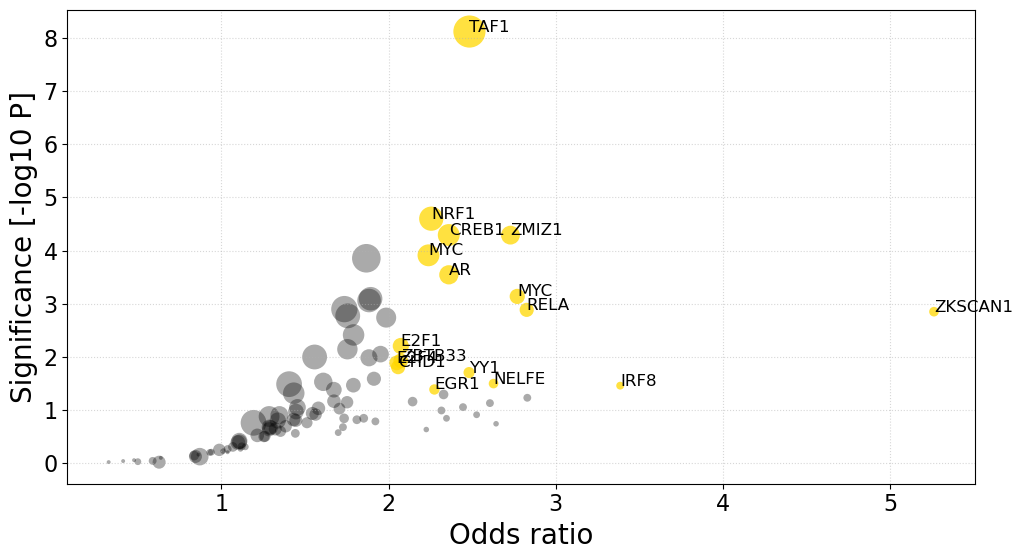

In [8]:
a = res_df[(res_df['pvalue'] > 0.05) | (res_df['odds_ratio'] < 2)]
print(a.shape)
x = a['odds_ratio']
y = -numpy.log10(a['pvalue'])
s = a['n_overlap']
matplotlib.pyplot.scatter(x, y, s*8, alpha=1/3, edgecolors='none', color='black')

b = res_df[(res_df['pvalue'] < 0.05) & (res_df['odds_ratio'] > 2)]
print(b.shape)
x = b['odds_ratio']
y = -numpy.log10(b['pvalue'])
s = b['n_overlap']
sc = matplotlib.pyplot.scatter(x, y, s*8, alpha=3/4, edgecolors='none', color='gold')

x = list(b['odds_ratio'])
y = list(-numpy.log10(b['pvalue']))
importance = [numpy.sqrt(x[i]**2 + y[i]**2) for i in range(len(x))]
b.loc[:, 'importance'] = importance
c = b.sort_values('importance', ascending=False)

threshold = 0 # seven
com = c[c['importance'] > threshold]
count = 0
for index, row in com.iterrows():
    x = row['odds_ratio']
    y = -numpy.log10(row['pvalue'])
    label = row['term'].split()[0]
    matplotlib.pyplot.text(x, y, label, fontsize=12)
    count = count + 1
    print('{}\t{}\t{}'.format(count, row['importance'], row['term']))

#matplotlib.pyplot.legend(*sc.legend_elements("sizes", num=4))
#matplotlib.pyplot.xlim(0, 17)
matplotlib.pyplot.xlabel('Odds ratio')
matplotlib.pyplot.ylabel('Significance [-log10 P]')
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()
matplotlib.pyplot.savefig('enriched04.svg')

In [9]:
%%time
tflink = pandas.read_csv(tftf_library, sep='\t')
tflink.shape

CPU times: user 7.73 s, sys: 1.32 s, total: 9.05 s
Wall time: 9.7 s


(6739357, 15)

In [10]:
tflink.head()

,UniprotID.TF,UniprotID.Target,NCBI.GeneID.TF,NCBI.GeneID.Target,Name.TF,Name.Target,Detection.method,PubmedID,Organism,Source.database,Small-scale.evidence,TF.TFLink.ortho,TF.nonTFLink.ortho,Target.TFLink.ortho,Target.nonTFLink.ortho
0,Q9H9S0,O94907,79923,22943,NANOG,DKK1,chromatin immunoprecipitation assay;inferred b...,19148141;29087512;29126285;27924024,Homo sapiens,GTRD;ReMap;TRRUST,Yes,-,-,Dr:Q9PWH3;Dr:F1RBK0;Mm:O54908,Rn:D3Z9J1
1,P37231,P10826,5468,5915,PPARG,RARB,chromatin immunoprecipitation assay;inferred b...,17202159;12839938;29087512;27924024,Homo sapiens,GTRD;TRED;TRRUST,Yes,-,-,Mm:P22605;Rn:D3ZFD9,-
2,P10242,P08047,4602,6667,MYB,SP1,chromatin immunoprecipitation assay;inferred b...,29126285;27924024;17202159,Homo sapiens,GTRD;ReMap;TRED,Yes,Dr:F1QP24;Rn:A0A0G2K2A4,Mm:A0A087WPA7,Dr:F1QW97;Rn:Q01714,Mm:G3X8Q0
3,P31269,Q02363,3205,3398,HOXA9,ID2,inferred by curator,29087512;20565746,Homo sapiens,TRRUST,Yes,Mm:P09631,Rn:D3ZSU5,Dr:Q7SZQ2;Mm:P41136;Rn:P41137,-
4,P03372,P17275,2099,3726,ESR1,JUNB,chromatin immunoprecipitation assay;inferred b...,29126285;18971253;27924024;11477071;17202159;2...,Homo sapiens,GTRD;PAZAR;ReMap;TRED;TRRUST,Yes,Mm:P19785,Rn:A0A0G2K0D4,Dr:A8E7N0;Mm:P09450;Rn:A0A0G2JSY8,-


In [11]:
# this is important. Working with small-scale experiments only makes the network more frugal. Otherwise more or less everything connects to everything.
small = tflink[tflink['Small-scale.evidence'] == 'Yes']
print(small.shape)

(16634, 15)


In [12]:
#targets = tflink[tflink['Name.TF'] == 'MYC']['Name.Target'].to_list()
#print(len(targets))

In [13]:
#print(tflink.shape)
#df = tflink[tflink['Name.TF'] == 'IRF8']
#print(df.shape)
#df = df[df['Name.Target'].isin(ourtfs)]
#print(df.shape)
#df

In [14]:
ourtfs = list(set([element.split(' ')[0] for element in c['term'].values]))
ourtfs.sort()

interactions = []

for tf in ourtfs:
    print(tf)
    df = small[small['Name.TF'] == tf]
    print(df.shape)
    df = df[df['Name.Target'].isin(ourtfs)]

    print(df.shape)
    print(df[['Name.TF', 'Name.Target']])

    for tmp, row in df.iterrows():
        print(ourtfs.index(row['Name.TF']), ourtfs.index(row['Name.Target'])) 

        a = ourtfs.index(row['Name.TF'])
        b = ourtfs.index(row['Name.Target'])
        interactions.append([a, b])
    
    print()

AR
(443, 15)
(4, 15)
      Name.TF Name.Target
1450       AR         MYC
5013       AR          AR
10861      AR       ZMIZ1
15785      AR        RELA
0 7
0 0
0 15
0 10

CHD1
(0, 15)
(0, 15)
Empty DataFrame
Columns: [Name.TF, Name.Target]
Index: []

CREB1
(245, 15)
(3, 15)
      Name.TF Name.Target
7209    CREB1          AR
8602    CREB1        NRF1
15112   CREB1        EGR1
2 0
2 9
2 5

E2F1
(772, 15)
(5, 15)
      Name.TF Name.Target
213      E2F1         MYC
3804     E2F1          AR
11473    E2F1         YY1
11739    E2F1        EGR1
12140    E2F1        E2F1
3 7
3 0
3 12
3 5
3 3

E2F4
(307, 15)
(3, 15)
     Name.TF Name.Target
933     E2F4        E2F1
5652    E2F4         MYC
9345    E2F4          AR
4 3
4 7
4 0

EGR1
(150, 15)
(3, 15)
      Name.TF Name.Target
8493     EGR1        RELA
10842    EGR1         MYC
14511    EGR1          AR
5 10
5 7
5 0

IRF8
(14, 15)
(0, 15)
Empty DataFrame
Columns: [Name.TF, Name.Target]
Index: []

MYC
(896, 15)
(5, 15)
      Name.TF Name.Target
32

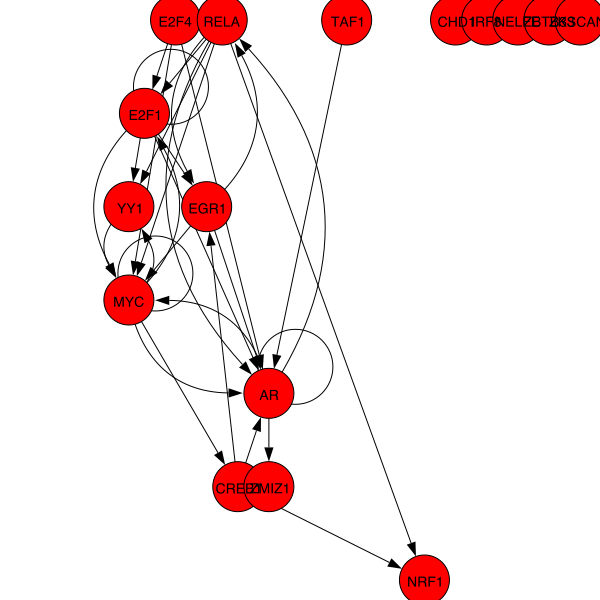

In [15]:
g = igraph.Graph(edges=interactions, directed=True)
g.vs["label"] = ourtfs

layout = g.layout("sugiyama") 
igraph.plot(g, layout=layout, vertex_size=50, edge_color='black')

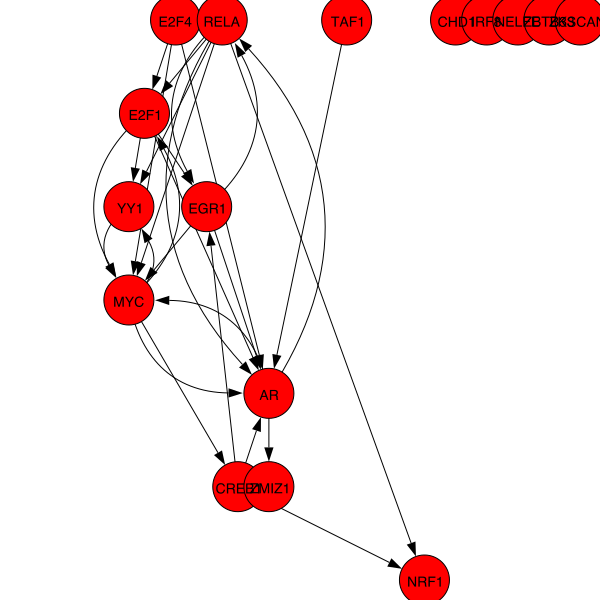

In [16]:
g2 = g.copy()
g2.simplify()
igraph.plot(g2, layout=layout, vertex_size=50, edge_color='black', target='network04.svg')